In [1]:
import numpy as np
import pandas as pd
import os
import glob
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
import yfinance as yf
from scipy import stats
import plotly.express as px
from sklearn.preprocessing import normalize
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import seaborn as sns
import math
import random
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.spatial.distance import cityblock
import copy

### Data Collection

In [2]:
DATA_PATH    = './downloader-data'
TICKERS_PATH = './tickers'
INDEX_PATH   = 'Datasets/INDEX/'
#INDEX_PATH   = 'Documents/GitHub/labs/fin-ops/Datasets/INDEX/'
#DATA_PATH    = 'Documents/GitHub/labs/fin-ops/downloader-data'
#TICKERS_PATH = 'Documents/GitHub/labs/fin-ops/tickers'

def read_tickers(stock_markets) -> pd.DataFrame:
    '''Returns pandas dataframe containing all tickers for the @stock_markets '''
    ticker_files = [f'{TICKERS_PATH}/{sm}.csv' for sm in stock_markets]
    tickers = pd.concat([pd.read_csv(tf) for tf in ticker_files], ignore_index=True)
    return tickers


stock_markets = ['NASDAQ']
tickers = read_tickers(stock_markets)
tickers

ticker                                            company
0      AAIT  iShares MSCI All Country Asia Information Tech...
1       AAL                      American Airlines Group, Inc.
2      AAME                      Atlantic American Corporation
3      AAOI                      Applied Optoelectronics, Inc.
4      AAON                                         AAON, Inc.
...     ...                                                ...
2962     ZN                                 Zion Oil & Gas Inc
2963   ZNGA                                         Zynga Inc.
2964   ZSPH                                    ZS Pharma, Inc.
2965     ZU                                       zulily, inc.
2966   ZUMZ                                        Zumiez Inc.

[2967 rows x 2 columns]

In [3]:
def read_historical_data(tickers):
    '''Returns dict {ticker : historical data for the ticker}'''
    data_for_ticker = {}
    for index, (ticker, name) in tickers.iterrows():
        try:
            data = pd.read_csv(f'{DATA_PATH}/{ticker}.csv')
            if len(data) > 100:
                data_for_ticker[ticker] = data
        except:
            pass
    return data_for_ticker


data_for_ticker = read_historical_data(tickers)

### Computing logret_mean and logret_std

In [4]:
def add_logret(ticker_data: pd.DataFrame, by_column='Close') -> pd.DataFrame:
    '''Returns @ticker_data with calculated "logret" and "-logret" columns'''
    ticker_data = ticker_data.assign(logret=np.log(ticker_data[by_column]).diff())
    ticker_data['-logret'] = ticker_data['logret'].mul(-1)
    return ticker_data


def get_logret_mean_std(tickers, data_map, by_column='Close') -> pd.DataFrame:
    '''Returns @result pd.DataFrame such that @result.loc[ticker] == [logret_mean, logret_std]'''
    result = pd.DataFrame(data=[], columns=['ticker', 'logret_mean', 'logret_std'])
    result.set_index('ticker', inplace=True)

    for ticker in tickers:
        if ticker in data_map:            
            ticker_data = data_map[ticker]
            ticker_logret = np.log(ticker_data[by_column]).diff()
            result.loc[ticker] = [ticker_logret.mean(), ticker_logret.std()]
    
    return result


for ticker in tickers.ticker:
    if ticker in data_for_ticker:       
        data_for_ticker[ticker] = add_logret(data_for_ticker[ticker])

estims = get_logret_mean_std(tickers.ticker, data_for_ticker)
estims

logret_mean  logret_std
ticker                         
AAL        0.000892    0.029198
AAME       0.002402    0.070546
AAOI      -0.001352    0.039404
AAON       0.000727    0.015276
AAPL       0.001315    0.015764
...             ...         ...
ZION       0.002000    0.022054
ZIOP      -0.002779    0.054918
ZIXI       0.000645    0.029291
ZNGA      -0.001244    0.025450
ZUMZ       0.000834    0.029358

[1686 rows x 2 columns]

# ДЗ-1: Карта активов, Равномерный портфель, индекс, VaR, White noise check

### Карта активов

In [5]:
ticker_colour = estims['logret_mean'] / estims['logret_std']
ticker_size = (ticker_colour - ticker_colour.min()) / ticker_colour.max()
fig = px.scatter(estims, x='logret_std', y='logret_mean',
                 hover_name=estims.index, 
                 color_continuous_scale=px.colors.diverging.RdYlGn,
                 color=ticker_colour)
fig.show()

### Равномерный портфель

In [6]:
uniform_logret_mean = estims['logret_mean'].mean()
uniform_logret_std = estims['logret_std'].mean()

print(f'UNIFORM std:{uniform_logret_std}, mean:{uniform_logret_mean}')

fig.add_scatter(x=[uniform_logret_std], y=[uniform_logret_mean], text=['Uniform Portfolio'], mode="markers",
                marker=dict(size=20, color="Blue"), name='UNIFORM', secondary_y=False)

fig.update_layout(
    legend = dict(
        x=0.89,
        y=1,
        traceorder="normal",
        font = dict(family = "Courier", size = 10)
    )
)
fig.show()

UNIFORM std:0.03548656148484477, mean:0.00043413894961391646


### Индекс NIFTY-50

In [7]:
index = pd.read_csv(f'{INDEX_PATH}/NIFTY 50.csv')
index = index.loc[index['Date'].str.startswith('2019')]
index

Date      Open      High       Low     Close       Volume  \
6890  2019-01-01  10881.70  10923.60  10807.10  10910.10  159404542.0   
6891  2019-01-02  10868.85  10895.35  10735.05  10792.50  309665939.0   
6892  2019-01-03  10796.80  10814.05  10661.25  10672.25  286241745.0   
6893  2019-01-04  10699.70  10741.05  10628.65  10727.35  296596655.0   
6894  2019-01-07  10804.85  10835.95  10750.15  10771.80  269371080.0   
...          ...       ...       ...       ...       ...          ...   
7130  2019-12-24  12269.25  12283.70  12202.10  12214.55  470290298.0   
7131  2019-12-26  12211.85  12221.55  12118.85  12126.55  520326632.0   
7132  2019-12-27  12172.90  12258.45  12157.90  12245.80  383788556.0   
7133  2019-12-30  12274.90  12286.45  12213.80  12255.85  411084614.0   
7134  2019-12-31  12247.10  12247.10  12151.80  12168.45  426931711.0   

          Turnover  
6890  8.688260e+10  
6891  1.535225e+11  
6892  1.503045e+11  
6893  1.451674e+11  
6894  1.273129e+11  
...            ...  
7130  1.386456e+11  
7131  1.636231e+11  
7132  1.367620e+11  
7133  1.455673e+11  
7134  1.481289e+11  

[245 rows x 7 columns]

In [8]:
index = index.assign(logret=np.log(index.Close).diff())
index_mean, index_std = index['logret'].mean(), index['logret'].std()

print(f'NIFTY-50 std:{index_std}, mean:{index_mean}')

fig.add_scatter(x=[index_std], y=[index_mean], mode="markers",
                marker=dict(size=20, color="Black"), text=['NIFTY-50'], name='NIFTY-50')

fig.update_layout(
    legend = dict(
        x=0.89,
        y=1,
        traceorder="normal",
        font = dict(family = "Courier", size = 10)
    )
)
fig.show()

NIFTY-50 std:0.008659345426548198, mean:0.000447367093507667


### VaR

In [9]:
def getVaR(data, tLVL):
    if isinstance(data, pd.DataFrame):
        return data.aggregate(getVaR, tLVL=tLVL)
    elif isinstance(data, pd.Series):
        return -np.percentile(data, tLVL)
    else:
        raise TypeError("Expected data to be a Series or DataFrame")
        
TRUST_LEVELS = [95]

tickersVaRs = pd.DataFrame(data=[], columns=['ticker'] + [f'VaR-{tLVL}' for tLVL in TRUST_LEVELS])

# compute VaR to tickers     
for index, (ticker, data) in enumerate(data_for_ticker.items()):
    tickersVaRs_row = [ticker]
    for tLVL in TRUST_LEVELS:
        quantile_value = getVaR(data['-logret'][1:], tLVL)
        tickersVaRs_row.append(quantile_value)
    tickersVaRs.loc[index] = tickersVaRs_row
            
# plot values     
tickersVaRs

ticker    VaR-95
0       AAL -0.042276
1      AAME -0.080964
2      AAOI -0.046862
3      AAON -0.024963
4      AAPL -0.025514
...     ...       ...
1681   ZION -0.030255
1682   ZIOP -0.081086
1683   ZIXI -0.038677
1684   ZNGA -0.040315
1685   ZUMZ -0.044529

[1686 rows x 2 columns]

In [10]:
for tLVL in TRUST_LEVELS:
    VaR_column = f'VaR-{tLVL}'
    tickersVaRs = tickersVaRs.sort_values(by=VaR_column, ascending=False)
    
    tLVL_fig = px.bar(tickersVaRs, x='ticker', y=VaR_column,
                 color=f'{VaR_column}', color_continuous_scale=px.colors.diverging.RdYlGn,
                 height=400)
    tLVL_fig.show()

#### Лучший VaR на карту активов

In [11]:
tickersVaRs = tickersVaRs.sort_values(by='VaR-95', ascending=False)
best_VaR_ticker = tickersVaRs['ticker'].iloc[0]
best_VaR_mean = estims.loc[best_VaR_ticker]['logret_mean']
best_VaR_std = estims.loc[best_VaR_ticker]['logret_std']

print(f'Best Var Ticker - {best_VaR_ticker}, std:{best_VaR_std}, mean:{best_VaR_mean}')

fig.add_scatter(x=[best_VaR_std], y=[best_VaR_mean], mode="markers",
                marker=dict(size=20, color="Brown"), text=['Best VaR'], name='Best VaR')

fig.update_layout(
    legend = dict(
        x=0.89,
        y=1,
        traceorder="normal",
        font = dict(family = "Courier", size = 10)
    )
)

Best Var Ticker - FTSM, std:0.0001494492130113972, mean:-1.2025347087067364e-06


### VaR индекса Nifty-50

In [12]:
index = pd.read_csv(f'{INDEX_PATH}/NIFTY 50.csv')
index = index.assign(logret=np.log(index.Close).diff())
index

Date      Open      High       Low     Close       Volume  \
0     1990-07-03      0.00      0.00      0.00    279.02          NaN   
1     1990-07-05      0.00      0.00      0.00    284.04          NaN   
2     1990-07-06      0.00      0.00      0.00    289.04          NaN   
3     1990-07-09      0.00      0.00      0.00    289.69          NaN   
4     1990-07-10      0.00      0.00      0.00    288.69          NaN   
...          ...       ...       ...       ...       ...          ...   
7505  2021-06-25  15839.35  15870.80  15772.30  15860.35  314614380.0   
7506  2021-06-28  15915.35  15915.65  15792.15  15814.70  255099272.0   
7507  2021-06-29  15807.50  15835.90  15724.05  15748.45  360334724.0   
7508  2021-06-30  15776.90  15839.10  15708.75  15721.50  262386323.0   
7509  2021-07-01  15755.05  15755.55  15667.05  15680.00  224921644.0   

          Turnover    logret  
0              NaN       NaN  
1              NaN  0.017832  
2              NaN  0.017450  
3              NaN  0.002246  
4              NaN -0.003458  
...            ...       ...  
7505  2.693322e+11  0.004417  
7506  1.871341e+11 -0.002882  
7507  2.439213e+11 -0.004198  
7508  2.037976e+11 -0.001713  
7509  1.735997e+11 -0.002643  

[7510 rows x 8 columns]

In [13]:
indexLogrets = pd.DataFrame()
index_logrets = np.log(index.Close).diff()
index_minus_logrets = index_logrets.mul(-1)
indexLogrets['logrets'] = index_logrets
indexLogrets['minus_logrets'] = index_minus_logrets

indexVaRs = []

for tLVL in TRUST_LEVELS:
        indexVaR = getVaR(indexLogrets['minus_logrets'][1:], tLVL)
        indexVaRs.append(indexVaR)
        
indexVaRs

[-0.023636268879667806]

In [14]:
tickersVaRs.loc[tickersVaRs.shape[0]] = [ 'NIFTY-50', indexVaRs[0] ]    

for tLVL in TRUST_LEVELS:
    VaR_column = f'VaR-{tLVL}'
    tickersVaRs = tickersVaRs.sort_values(by=VaR_column, ascending=False)
    tLVL_fig = px.bar(tickersVaRs, x='ticker', y=VaR_column,
                 color=f'{VaR_column}', color_continuous_scale=px.colors.diverging.RdYlGn,
                 height=400)
    tLVL_fig.show()

### VaR универсального портфеля

In [15]:
uniformVaRs = []
uniform_minus_logrets = estims['logret_mean'].mul(-1)
for tLVL in TRUST_LEVELS:
        uniformVaR = getVaR(uniform_minus_logrets, tLVL) * 11
        uniformVaRs.append(uniformVaR)
uniformVaRs

[-0.03108042604641483]

In [16]:
tickersVaRs.loc[tickersVaRs.shape[0]] = [ 'Uniform Portfolio', uniformVaRs[0] ]    

for tLVL in TRUST_LEVELS:
    VaR_column = f'VaR-{tLVL}'
    tickersVaRs = tickersVaRs.sort_values(by=VaR_column, ascending=False)
    tLVL_fig = px.bar(tickersVaRs, x='ticker', y=VaR_column,
                 color=f'{VaR_column}', color_continuous_scale=px.colors.diverging.RdYlGn,
                 height=400)
    tLVL_fig.show()

### 6 - White Noise Check

In [17]:
best_var_tickers = tickersVaRs['ticker'].iloc[2:6].values
for ticker in best_var_tickers:
    print(ticker)

ULTR
VCSH
LMBS
GSIG


In [18]:
joint_data = pd.DataFrame(data=[], columns=[])
joint_data['Date'] = data_for_ticker[best_var_tickers[0]]['Date'][1:]

for ticker in best_var_tickers:
    data = data_for_ticker[ticker]
    joint_data[ticker] = data['logret'][1:]
    
print(joint_data)

           Date      ULTR      VCSH      LMBS      GSIG
1    2020-12-01  0.000121 -0.000614 -0.000775 -0.000417
2    2020-12-02  0.000804  0.000000 -0.002135  0.000099
3    2020-12-03  0.000302  0.000482  0.000194  0.000318
4    2020-12-04  0.000402 -0.000482 -0.000389 -0.000218
5    2020-12-07 -0.000100  0.000843  0.000194  0.000318
..          ...       ...       ...       ...       ...
248  2021-11-23  0.000000 -0.000614 -0.002593       NaN
249  2021-11-24 -0.000507 -0.000369  0.000200       NaN
250  2021-11-26  0.001015  0.001965  0.000599       NaN
251  2021-11-29 -0.000406  0.000859  0.000000       NaN
252  2021-11-30  0.000203 -0.000123  0.001197       NaN

[252 rows x 5 columns]


In [19]:
print(joint_data.describe())

             ULTR        VCSH        LMBS        GSIG
count  252.000000  252.000000  252.000000  229.000000
mean     0.000008   -0.000034   -0.000057   -0.000037
std      0.000787    0.000859    0.000892    0.000945
min     -0.006439   -0.004831   -0.004104   -0.005234
25%     -0.000302   -0.000397   -0.000397   -0.000403
50%      0.000000    0.000000    0.000000    0.000040
75%      0.000303    0.000483    0.000396    0.000497
max      0.006439    0.001965    0.004883    0.003798


In [20]:
fig = make_subplots(rows=2, cols=2, subplot_titles=best_var_tickers)
plots = sorted([[row, col] for col in range(1, 3) for row in range(1, 3)])

for ticker, (row, col) in zip(best_var_tickers, plots):
    fig.add_trace(
        go.Scatter(name=ticker, x=joint_data['Date'],
                   y=joint_data[ticker]),
        row=row, 
        col=col
    )
    
fig.show()

In [21]:

fig = make_subplots(rows=2, cols=2, subplot_titles=best_var_tickers)
plots = sorted([[row, col] for col in range(1, 3) for row in range(1, 3)])

for ticker, (row, col) in zip(best_var_tickers, plots):
    fig.add_trace(
        go.Histogram(name=ticker, x=joint_data[ticker]),
        row=row, 
        col=col
    )
    
fig.show()

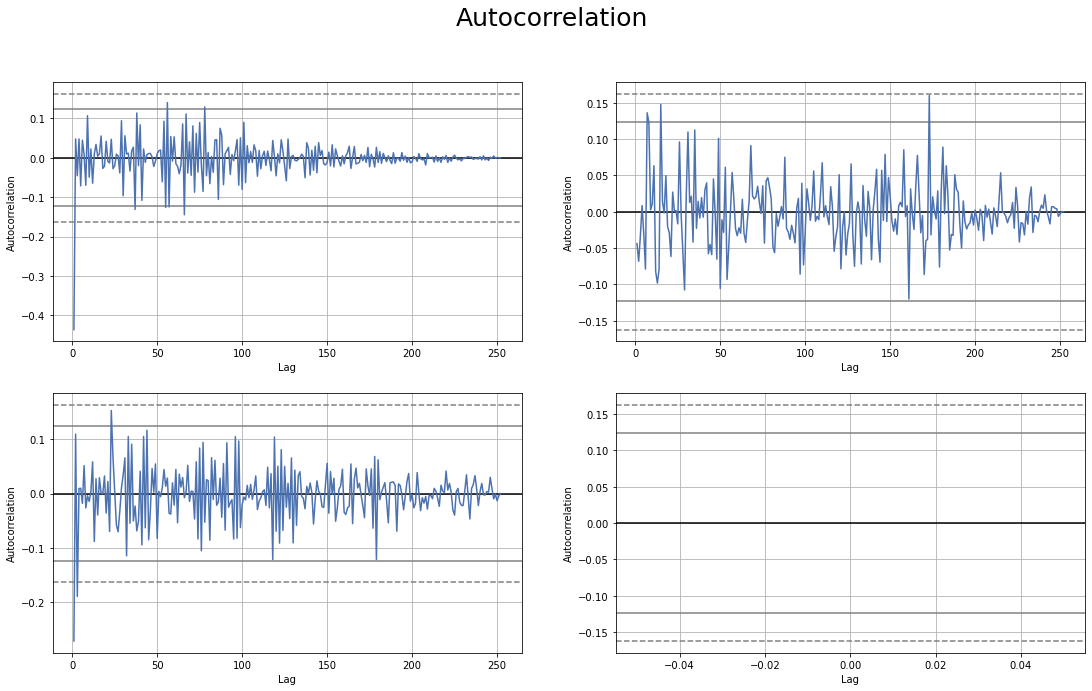

In [22]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Autocorrelation', fontsize=25)
fig.set_size_inches(18.5, 10.5)
plots = sorted([[row, col] for col in range(0, 2) for row in range(0, 2)])

for ticker, (row, col) in zip(best_var_tickers, plots):
    autocorrelation_plot(joint_data[ticker], ax=axs[row, col])

In [23]:
warnings.filterwarnings("ignore")

pvalues = []

joint_data = joint_data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

for ticker in best_var_tickers:
    # fit ARMA model to data
    res = sm.tsa.ARMA(joint_data[ticker], (1,1)).fit(disp=-1)
    # perform Ljung-Box test on residuals with lag=5
    stat, pvalue = sm.stats.acorr_ljungbox(res.resid, lags=[5])
    pvalues.append(pvalue[0])

In [24]:

alpha = 0.05

pvalues_fig = px.bar(x=['alpha', *best_var_tickers], 
                     y=[alpha, *pvalues],
                     color=[alpha, *pvalues],
                     color_continuous_scale=px.colors.diverging.RdYlGn[::-1],
                     height=400, title='Ljung-Box test p-values')

pvalues_fig.show()

### Heat Map

In [25]:
joint_data = pd.DataFrame(data=[], columns=[])
joint_data['Date'] = data_for_ticker[tickers.ticker[1]]['Date'][1:]

for ticker in tickers.ticker:
    if ticker in data_for_ticker:        
        data = data_for_ticker[ticker]
        joint_data[ticker] = data['logret'][1:]
    
joint_data = joint_data.dropna()
del joint_data['Date']
joint_data

AAL      AAME      AAOI      AAON      AAPL      AAWW      AAXJ  \
1    0.009859  0.009302 -0.019442 -0.013759  0.030362 -0.022469  0.014490   
2    0.040514 -0.009302  0.020644 -0.007971  0.002929 -0.005513  0.001507   
3    0.079525  0.009302 -0.014528 -0.027521 -0.001138  0.031380  0.009913   
4    0.019083  0.009217  0.030032  0.007232 -0.005628  0.006585  0.009929   
5    0.048209 -0.013857 -0.007126 -0.004815  0.012195 -0.015194 -0.002046   
..        ...       ...       ...       ...       ...       ...       ...   
100  0.043112  0.046406  0.001208 -0.018216  0.002974 -0.005776  0.001267   
101 -0.012786 -0.041419 -0.018282 -0.000146 -0.002453  0.024356  0.000738   
102 -0.002761  0.065005  0.008573 -0.006147 -0.006045  0.007509  0.004523   
103 -0.018605 -0.025976 -0.036006 -0.008108 -0.000749 -0.005626 -0.000735   
104  0.019526 -0.021766 -0.065297 -0.032341 -0.015249 -0.017661 -0.016200   

         ABCB      ABIO      ABMD  ...        YY         Z      ZBRA  \
1    0.023825 -0.011862 -0.021723  ... -0.008230 -0.005767 -0.016654   
2    0.026631  0.018913 -0.011097  ... -0.030340 -0.000840 -0.013417   
3   -0.008986 -0.002345  0.005976  ... -0.008319  0.001586  0.013954   
4    0.022592 -0.016568  0.021393  ...  0.001411 -0.002801  0.016249   
5    0.015598 -0.024156 -0.002681  ...  0.008308  0.045236 -0.012336   
..        ...       ...       ...  ...       ...       ...       ...   
100  0.011934  0.014025 -0.008095  ...  0.003626  0.030126  0.002189   
101  0.014097 -0.011205 -0.021980  ... -0.008380 -0.015704  0.006498   
102  0.009922  0.011205  0.030474  ... -0.010805 -0.022704 -0.010317   
103  0.031399 -0.025389 -0.083804  ... -0.016951 -0.025569  0.000060   
104 -0.004795 -0.017291 -0.006867  ... -0.009111 -0.017673 -0.018063   

         ZEUS      ZGNX      ZION      ZIOP      ZIXI      ZNGA      ZUMZ  
1    0.012722  0.005120  0.037635  0.017700  0.001388 -0.001213  0.005914  
2    0.017805 -0.002324  0.037472 -0.021277 -0.002778  0.009662  0.020428  
3   -0.009193  0.027085  0.019520 -0.014441 -0.002786  0.011948  0.007587  
4    0.050798  0.006770  0.037024  0.028676  0.051642  0.041867 -0.043954  
5   -0.018349 -0.037118 -0.025539 -0.035975  0.010540  0.010198  0.021286  
..        ...       ...       ...       ...       ...       ...       ...  
100  0.032869  0.012020  0.006245  0.070204  0.065640  0.033183 -0.043926  
101  0.022216 -0.005731  0.009840 -0.008511  0.003805 -0.000907  0.021863  
102 -0.020515  0.008325  0.001812  0.000000 -0.008900  0.003623 -0.004563  
103 -0.007161 -0.013038  0.019891 -0.017242  0.011429  0.005410  0.009559  
104 -0.005835 -0.008434 -0.009986  0.002894 -0.003795 -0.027349 -0.027091  

[104 rows x 1686 columns]

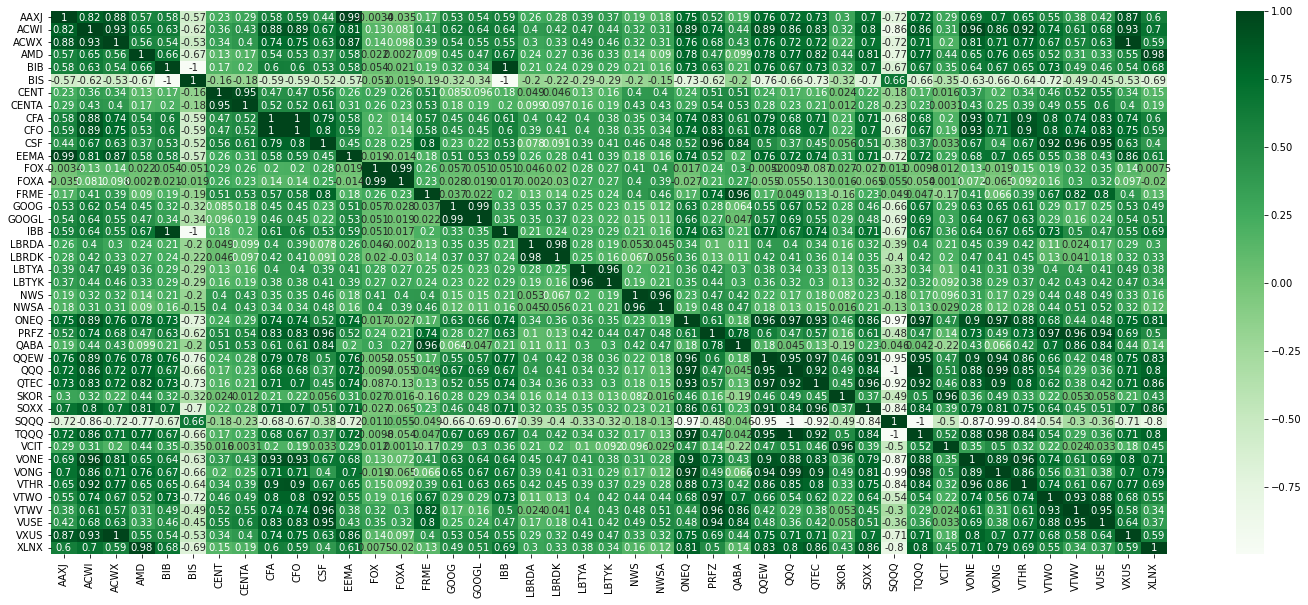

In [26]:
joint_data = joint_data.dropna()

def plot_heat_map(data, figx, figy):
    plt.figure(figsize=(figx,figy))
    sns.heatmap(data, annot=True, cmap="Greens")
    plt.show()



border = 0.95 
correlation_matrix = joint_data.corr()
m = (correlation_matrix.mask(np.eye(len(correlation_matrix), dtype=bool)).abs() > border).any()
correlation_matrix = correlation_matrix.loc[m, m]
plot_heat_map(correlation_matrix,25,10)

# ДЗ-2: Эффективные фронты, оптимальные портфели

Выбираем самые зеленые тикеры

In [27]:
ticker_colour.sort_values(ascending=False)
portfolio = ticker_colour.sort_values(ascending=False)[:50]
best50 = portfolio.keys()
best50 = list(best50)
print(best50)

['PRFT', 'DXLG', 'FTNT', 'WIRE', 'GAIN', 'SYNA', 'NYMTP', 'ANAT', 'TRNS', 'HMHC', 'SFBS', 'CRVL', 'COKE', 'TBK', 'SBNY', 'TGLS', 'UAE', 'HIFS', 'CFNB', 'IMKTA', 'CG', 'BKEPP', 'OTTR', 'III', 'NDAQ', 'LAND', 'PMBC', 'OFS', 'ODFL', 'TGA', 'PSEC', 'CBNK', 'HAFC', 'OXLCP', 'RRD', 'INTU', 'MSFT', 'CROX', 'SVBI', 'NVDA', 'HSON', 'PFBC', 'SMBC', 'KFRC', 'UHAL', 'NAVI', 'SLCT', 'HMNF', 'CLMT', 'CAR']


In [28]:
joint_data = pd.DataFrame(data=[], columns=[])
joint_data['Date'] = data_for_ticker[best50[0]]['Date'][1:]

for ticker in best50:
    data = data_for_ticker[ticker]
    joint_data[ticker] = data['logret'][1:]
    
joint_data = joint_data.dropna()
del joint_data['Date']
joint_data

PRFT      DXLG      FTNT      WIRE      GAIN      SYNA     NYMTP  \
1    0.000439  0.055570 -0.004799  0.012693  0.017026  0.012142  0.006378   
2    0.019996 -0.027399  0.001955 -0.008251 -0.000994 -0.009188 -0.000454   
3    0.036345  0.027399  0.025788  0.000385  0.009891  0.003839  0.006792   
4    0.018708  0.000000  0.013471  0.042054  0.011742  0.044218  0.018776   
5   -0.016220 -0.084557  0.002189  0.012662 -0.005854  0.001343  0.002654   
..        ...       ...       ...       ...       ...       ...       ...   
103  0.019376  0.033902 -0.012911 -0.008863  0.006265  0.001319  0.000000   
104  0.007189  0.026317  0.043840 -0.007736 -0.012570 -0.029794 -0.001228   
105  0.010160  0.006473 -0.005155  0.030463 -0.008469 -0.011939 -0.006161   
106  0.013636  0.012821  0.017563  0.014827 -0.016435 -0.021280 -0.000412   
107 -0.005223  0.000000  0.012495  0.001918  0.002159 -0.007046  0.007801   

         ANAT      TRNS      HMHC  ...      HSON      PFBC      SMBC  \
1    0.021125 -0.009509  0.022989  ...  0.039523  0.022056  0.001323   
2   -0.004630 -0.000319  0.031952  ...  0.015940  0.016098  0.013136   
3    0.001171  0.009827  0.069831  ...  0.012020  0.013779 -0.000979   
4    0.008621  0.023384  0.005848  ...  0.083712  0.060366  0.015554   
5    0.000000  0.037797  0.037200  ... -0.065497  0.023305 -0.012620   
..        ...       ...       ...  ...       ...       ...       ...   
103  0.018499 -0.006315  0.035559  ...  0.000563  0.000302  0.013407   
104 -0.015495 -0.010148 -0.008772  ... -0.001689 -0.011982  0.014185   
105  0.030838  0.008365  0.006586  ...  0.016760  0.021136  0.004525   
106 -0.012568 -0.016397  0.006543  ... -0.008904  0.000299 -0.012434   
107  0.007422 -0.008097 -0.010929  ...  0.034609  0.007588  0.014808   

         KFRC      UHAL      NAVI      SLCT      HMNF      CLMT       CAR  
1    0.002676  0.017398  0.035128  0.009788  0.006169 -0.002759  0.039308  
2    0.005814  0.008246 -0.000515 -0.003252  0.009792  0.008253  0.029628  
3   -0.001214  0.003336  0.011464  0.004334  0.019898  0.002736  0.015798  
4    0.040482  0.017205 -0.008325  0.044405 -0.015644  0.029612  0.036927  
5   -0.004913 -0.014068 -0.002092 -0.028319 -0.026422 -0.029612 -0.033797  
..        ...       ...       ...       ...       ...       ...       ...  
103 -0.003565 -0.003565  0.047319  0.000000  0.000978 -0.025233 -0.005776  
104  0.000714  0.005108 -0.009168  0.013664  0.004391  0.026892  0.017676  
105  0.023630  0.000771  0.002374  0.018488  0.000000  0.021330 -0.006718  
106  0.073884 -0.001626 -0.012526 -0.007522  0.001459  0.014505 -0.065700  
107 -0.036931  0.013099  0.013119  0.054685 -0.005851  0.023717  0.007292  

[107 rows x 50 columns]

In [29]:
logret_mean = joint_data.mean()
logret_std =  joint_data.cov()

### Доходность и риск портфеля по его весам

In [30]:
def get_portfolio_coordinates(weights,
                              _tickers=tickers,
                              _logret_mean=logret_mean,
                              _logret_std=logret_std):
    portfolio_logret_mean = 0
    portfolio_logret_std = 0
     
    for i in range(len(_tickers)):
        portfolio_logret_mean += weights[i] * _logret_mean[i]
        for j in range(len(_tickers)):
            portfolio_logret_std += weights[i] * weights[j] * _logret_std.loc[_tickers[i], _tickers[j]]
            
    portfolio_logret_std = math.sqrt(portfolio_logret_std)
    return portfolio_logret_std, portfolio_logret_mean 

### Uniform portfolio logret_mean, logret_std

In [31]:
uniform_weights = [1/len(best50)]*len(best50)
uniform_logret_std, uniform_logret_mean = get_portfolio_coordinates(uniform_weights, _tickers=best50)
print(f'Uniform portfolio (std, mean): ({uniform_logret_std}, {uniform_logret_mean})')

Uniform portfolio (std, mean): (0.009007585385502326, 0.004529878807772161)


In [32]:
def getRandomWeights(n, shorts=False):
    left, right = 0, 100    
    if shorts:
        left = -100     
    weights = [random.randint(left, right) for i in range(0, n)]
    weights = [weight/sum(map(abs, weights)) for weight in weights]
    return weights

## Portfolio without short sales

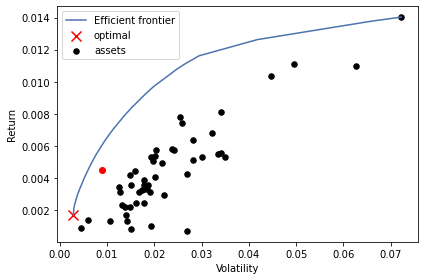

In [33]:
ef_no_shorts = CLA(logret_mean, logret_std, weight_bounds=(0,1))

minvol_ef = ef_no_shorts.min_volatility()
minvol_ef_pwt = ef_no_shorts.clean_weights()


ef_plt_no_shorts = efficient_frontier_no_shorts = pplt.plot_efficient_frontier(ef_no_shorts, showfig = False)
ef_plt_no_shorts.plot(uniform_logret_std, uniform_logret_mean, '-ro', label='uniform portfolio')

## Efficient frontier with short sales: 

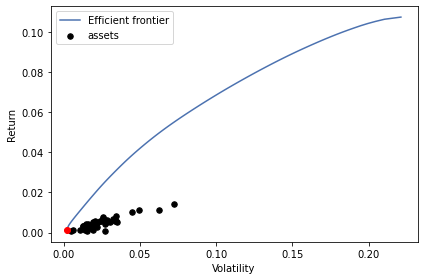

In [34]:
ef_shorts = EfficientFrontier(logret_mean, logret_std, weight_bounds=(-1,1))
ef_shorts_copy = EfficientFrontier(logret_mean, logret_std, weight_bounds=(-1,1))


minvol_ef_shorts = ef_shorts_copy.min_volatility()
minvol_ef_shorts_pwt = ef_shorts_copy.clean_weights()
minvol_ef_shorts_pwt = list(minvol_ef_shorts_pwt.values())

minvol_logret_std, minvol_logret_mean = get_portfolio_coordinates(minvol_ef_shorts_pwt, _tickers=best50)

ef_plt_shorts = pplt.plot_efficient_frontier(ef_shorts, showfig = False)
ef_plt_shorts.plot(minvol_logret_std, minvol_logret_mean, '-ro', label='uniform portfolio')

## Portfolio with short sales with 10 stocks

In [35]:
tickers10 = best50[:10]
tickers10

['PRFT',
 'DXLG',
 'FTNT',
 'WIRE',
 'GAIN',
 'SYNA',
 'NYMTP',
 'ANAT',
 'TRNS',
 'HMHC']

In [36]:
joint_data10 = pd.DataFrame(data=[], columns=[])
joint_data10['Date'] = data_for_ticker[tickers10[0]]['Date'][1:]

for ticker in tickers10:
    data = data_for_ticker[ticker]
    joint_data10[ticker] = data['logret'][1:]
    
joint_data10 = joint_data10.dropna()
del joint_data10['Date']
joint_data10

PRFT      DXLG      FTNT      WIRE      GAIN      SYNA     NYMTP  \
1    0.000439  0.055570 -0.004799  0.012693  0.017026  0.012142  0.006378   
2    0.019996 -0.027399  0.001955 -0.008251 -0.000994 -0.009188 -0.000454   
3    0.036345  0.027399  0.025788  0.000385  0.009891  0.003839  0.006792   
4    0.018708  0.000000  0.013471  0.042054  0.011742  0.044218  0.018776   
5   -0.016220 -0.084557  0.002189  0.012662 -0.005854  0.001343  0.002654   
..        ...       ...       ...       ...       ...       ...       ...   
248 -0.014811 -0.085927 -0.010087  0.004266  0.002385 -0.005808  0.000396   
249  0.020058  0.038270  0.017436 -0.000541  0.013606  0.018835  0.000000   
250 -0.038364 -0.011328 -0.017711 -0.063646 -0.013606 -0.023240  0.000000   
251  0.030230 -0.069445  0.047452  0.032120 -0.013190  0.044863  0.002765   
252 -0.009659 -0.030305 -0.033138 -0.020087 -0.002417 -0.007061 -0.002370   

         ANAT      TRNS      HMHC  
1    0.021125 -0.009509  0.022989  
2   -0.004630 -0.000319  0.031952  
3    0.001171  0.009827  0.069831  
4    0.008621  0.023384  0.005848  
5    0.000000  0.037797  0.037200  
..        ...       ...       ...  
248  0.002832 -0.050000  0.026412  
249 -0.005830 -0.013281  0.000592  
250 -0.002901 -0.038786 -0.051636  
251  0.000053  0.014694 -0.019516  
252 -0.000317 -0.009397 -0.010866  

[252 rows x 10 columns]

In [37]:
logret_mean10 = joint_data10.mean()
logret_std10 =  joint_data10.cov()

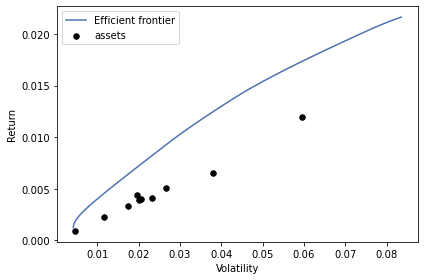

In [38]:
ef_shorts10 = EfficientFrontier(logret_mean10, logret_std10, weight_bounds=(-1,1))

ef_plt_shorts10 = pplt.plot_efficient_frontier(ef_shorts10, showfig = False)

## Portfolio without short sales with 10 stocks

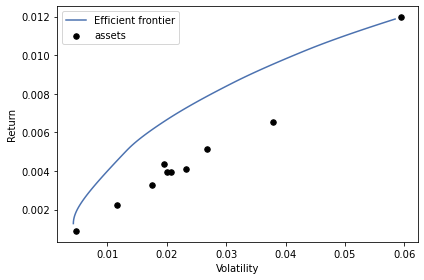

In [39]:
ef_no_shorts10 = EfficientFrontier(logret_mean10, logret_std10, weight_bounds=(0,1))
ef_plt_no_shorts10 = pplt.plot_efficient_frontier(ef_no_shorts10, showfig = False)

## Optimal portfolio without short sales with 50 stocks

In [40]:
def getVaR(portfolio_mean, portfolio_std, tLvl):
    quantile = stats.norm.ppf(tLvl)
    return (portfolio_mean + portfolio_std*quantile)

In [41]:
ef_no_shorts = CLA(logret_mean, logret_std, weight_bounds=(0,1))
optimal_pfolio = ef_no_shorts.max_sharpe() 
optimal_pwt = ef_no_shorts.clean_weights()
optimal_pwt

OrderedDict([('PRFT', 0.0),
             ('DXLG', 0.01866),
             ('FTNT', 0.02257),
             ('WIRE', 0.0),
             ('GAIN', 0.0),
             ('SYNA', 0.0),
             ('NYMTP', 0.23031),
             ('ANAT', 0.0),
             ('TRNS', 0.0),
             ('HMHC', 0.00983),
             ('SFBS', 0.0),
             ('CRVL', 0.0),
             ('COKE', 0.0),
             ('TBK', 0.0),
             ('SBNY', 0.0186),
             ('TGLS', 0.01776),
             ('UAE', 0.0),
             ('HIFS', 0.0),
             ('CFNB', 0.07803),
             ('IMKTA', 0.03992),
             ('CG', 0.0),
             ('BKEPP', 0.08984),
             ('OTTR', 0.0),
             ('III', 0.00904),
             ('NDAQ', 0.0294),
             ('LAND', 0.0),
             ('PMBC', 0.04873),
             ('OFS', 0.02305),
             ('ODFL', 0.0),
             ('TGA', 0.0),
             ('PSEC', 0.03802),
             ('CBNK', 0.02282),
             ('HAFC', 0.0),
             ('OXLCP',

In [42]:
optimal_weights = list(optimal_pwt.values())

optimal_logret_std, optimal_logret_mean = get_portfolio_coordinates(optimal_weights, _tickers=best50)

print('VaR for optimal portfolio without shorts', getVaR(optimal_logret_mean, optimal_logret_std, 0.95))

VaR for optimal portfolio without shorts 0.009805953127125455


## Optimal portfolio with short sales with 50 stocks

In [43]:
ef_shorts = CLA(logret_mean, logret_std, weight_bounds=(-1,1))
optimal_pfolio_short = ef_shorts.max_sharpe() 
optimal_pwt_short = ef_shorts.clean_weights()
optimal_pwt_short

OrderedDict([('PRFT', -0.07835),
             ('DXLG', 0.01617),
             ('FTNT', 0.09236),
             ('WIRE', 0.02762),
             ('GAIN', 0.02634),
             ('SYNA', -0.00985),
             ('NYMTP', 0.29153),
             ('ANAT', 0.04458),
             ('TRNS', -0.02286),
             ('HMHC', 0.03992),
             ('SFBS', 0.02478),
             ('CRVL', -0.00413),
             ('COKE', -0.10398),
             ('TBK', 0.03102),
             ('SBNY', 0.05529),
             ('TGLS', -0.00767),
             ('UAE', -0.00854),
             ('HIFS', 0.05993),
             ('CFNB', 0.06614),
             ('IMKTA', -0.00162),
             ('CG', 0.04253),
             ('BKEPP', 0.05611),
             ('OTTR', 0.01979),
             ('III', 0.00333),
             ('NDAQ', 0.16304),
             ('LAND', 0.00496),
             ('PMBC', 0.05733),
             ('OFS', 0.02271),
             ('ODFL', -0.0942),
             ('TGA', 0.01837),
             ('PSEC', 0.06561),
    

In [44]:
optimal_weights_short = list(optimal_pwt_short.values())

optimal_short_logret_std, optimal_short_logret_mean = get_portfolio_coordinates(optimal_weights_short, _tickers=best50)

print('VaR for optimal portfolio with shorts', getVaR(optimal_short_logret_mean, optimal_short_logret_std, 0.95))

VaR for optimal portfolio with shorts 0.010697016494357316


## Optimal portfolio without short sales with 10 stocks

In [45]:
ef_no_shorts10 = CLA(logret_mean10, logret_std10, weight_bounds=(0,1))
optimal_pfolio10 = ef_no_shorts10.max_sharpe() 
optimal_pwt10 = ef_no_shorts10.clean_weights()
optimal_pwt10

OrderedDict([('PRFT', 0.06015),
             ('DXLG', 0.04149),
             ('FTNT', 0.07597),
             ('WIRE', 0.04615),
             ('GAIN', 0.04376),
             ('SYNA', 0.01436),
             ('NYMTP', 0.53583),
             ('ANAT', 0.1141),
             ('TRNS', 0.05076),
             ('HMHC', 0.01745)])

In [46]:
optimal_weights10 = list(optimal_pwt10.values())

optimal10_logret_std, optimal10_logret_mean = get_portfolio_coordinates(weights=optimal_weights10, 
                                                                        _tickers=tickers10, 
                                                                        _logret_mean=logret_mean10, 
                                                                        _logret_std=logret_std10)

print('Var = ', getVaR(optimal10_logret_mean, optimal10_logret_std, 0.95))

Var =  0.012667652256284814


## Optimal portfolio with short sales with 10 stocks

In [47]:
ef_shorts10 = CLA(logret_mean10, logret_std10, weight_bounds=(-1,1))
optimal_pfolio_short10 = ef_shorts10.max_sharpe() 
optimal_pwt_short10 = ef_shorts10.clean_weights()
optimal_pwt_short10

OrderedDict([('PRFT', 0.06015),
             ('DXLG', 0.04149),
             ('FTNT', 0.07597),
             ('WIRE', 0.04615),
             ('GAIN', 0.04376),
             ('SYNA', 0.01436),
             ('NYMTP', 0.53583),
             ('ANAT', 0.1141),
             ('TRNS', 0.05076),
             ('HMHC', 0.01745)])

In [48]:
optimal_weights_short10 = list(optimal_pwt_short10.values())

optimal10_short_logret_std, optimal10_short_logret_mean = get_portfolio_coordinates(weights=optimal_weights_short10, 
                                                                        _tickers=tickers10, 
                                                                        _logret_mean=logret_mean10, 
                                                                        _logret_std=logret_std10)

print('Var = ', getVaR(optimal10_short_logret_mean, optimal10_short_logret_std, 0.95))

Var =  0.012667652256284814


## Risk-free asset 

возьмем виртуальный безрисковый актив и отобразим его на карте активов

ожидаемая доходность актива = 0.002

In [50]:
rf_logret_mean = 0.002
rf_logret_std = 0


### Risk-free with shorts 

построим оптимальный фронт в случае с  короткими продажами и отметим на нем безрисковый актив

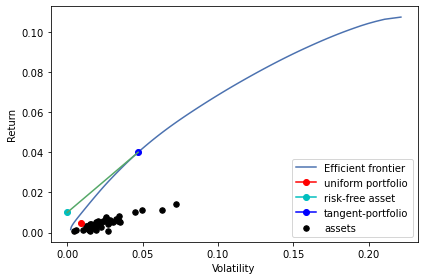

In [52]:
rf_logret_mean = 0.01

ef_shorts = EfficientFrontier(logret_mean, logret_std, weight_bounds=(-1,1))
ef_plt_shorts = pplt.plot_efficient_frontier(ef_shorts, showfig = False)
ef_plt_shorts.plot(uniform_logret_std, uniform_logret_mean, '-ro', label='uniform portfolio')
ef_plt_shorts.plot(rf_logret_std, rf_logret_mean, '-co', label='risk-free asset')

tangent_portfolio = ef_shorts.efficient_return(target_return=0.04)
tangent_portfolio_weights = list(tangent_portfolio.values())
tangent_logret_std, tangent_logret_mean = get_portfolio_coordinates(tangent_portfolio_weights, _tickers=best50)
ef_plt_shorts.plot(tangent_logret_std, tangent_logret_mean, '-bo', label='tangent-portfolio')

point1 = [rf_logret_std, rf_logret_mean]
point2 = [tangent_logret_std, tangent_logret_mean]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values)


legend = plt.legend(loc='lower right')
plt.show()

In [55]:
tangent_portfolio_weights[:40]

tangent_logret_std, tangent_logret_mean = get_portfolio_coordinates(weights=tangent_portfolio_weights, _tickers=tickers10)
tangent_var = getVaR(tangent_logret_mean, tangent_logret_std, 0.95)

print(f'(std, mean): {tangent_logret_std}, {tangent_logret_mean}')
print(f'var: {tangent_var}')
optimal_pwt10

(std, mean): 0.04525506442306608, 0.01389467675670043
var: 0.08833263361090321


OrderedDict([('PRFT', 0.06015),
             ('DXLG', 0.04149),
             ('FTNT', 0.07597),
             ('WIRE', 0.04615),
             ('GAIN', 0.04376),
             ('SYNA', 0.01436),
             ('NYMTP', 0.53583),
             ('ANAT', 0.1141),
             ('TRNS', 0.05076),
             ('HMHC', 0.01745)])

### Risk-free w/o shorts 

построим оптимальный фронт без коротких продаж и отметим на нем безрисковый актив

доходность безрискового актива выше доходности портфелей на оптимальном фронте

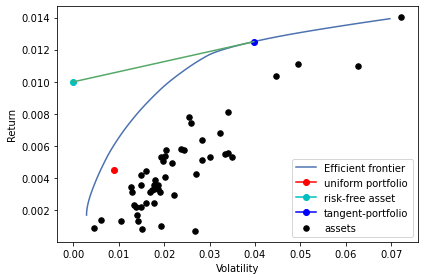

In [57]:
rf_logret_mean = 0.01

ef_shorts = EfficientFrontier(logret_mean, logret_std, weight_bounds=(0,1))
ef_plt_shorts = pplt.plot_efficient_frontier(ef_shorts, showfig = False)
ef_plt_shorts.plot(uniform_logret_std, uniform_logret_mean, '-ro', label='uniform portfolio')
ef_plt_shorts.plot(rf_logret_std, rf_logret_mean, '-co', label='risk-free asset')

tangent_portfolio = ef_shorts.efficient_return(target_return=0.0125)
tangent_portfolio_weights = list(tangent_portfolio.values())
tangent_logret_std, tangent_logret_mean = get_portfolio_coordinates(tangent_portfolio_weights, _tickers=best50)
ef_plt_shorts.plot(tangent_logret_std, tangent_logret_mean, '-bo', label='tangent-portfolio')

point1 = [rf_logret_std, rf_logret_mean]
point2 = [tangent_logret_std, tangent_logret_mean]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values)

legend = plt.legend(loc='lower right')
plt.show()

In [60]:
tangent_portfolio_weights[:40]

tangent_logret_std, tangent_logret_mean = get_portfolio_coordinates(weights=tangent_portfolio_weights, _tickers=tickers10)
tangent_var = getVaR(tangent_logret_mean, tangent_logret_std, 0.95)

print(f'(std, mean): {tangent_logret_std}, {tangent_logret_mean}')
print(f'var: {tangent_var}')
optimal_pwt10

(std, mean): 0.03579712442745898, 0.007261235776330584
var: 0.06614226572526963


OrderedDict([('PRFT', 0.06015),
             ('DXLG', 0.04149),
             ('FTNT', 0.07597),
             ('WIRE', 0.04615),
             ('GAIN', 0.04376),
             ('SYNA', 0.01436),
             ('NYMTP', 0.53583),
             ('ANAT', 0.1141),
             ('TRNS', 0.05076),
             ('HMHC', 0.01745)])

# ДЗ-3: Неопределённость портфелей, оптимизация CVaR

In [66]:
assets = ['MDLZ', 'MSFT', 'NXPI', 'PCAR', 'INTC',
          'NVDA', 'ILMN', 'DXCM', 'ROST', 'LULU',
          'PRFT', 'FTNT', 'WIRE', 'NFLX', 'GAIN',
          'SYNA', 'NYMTP', 'ANAT', 'TRNS', 'SFBS']

assets_data = {}
for asset in assets:
    assets_data[asset] = data_for_ticker[asset]

In [67]:
for ticker in assets_data.keys():
    assets_data[ticker] = add_logret(assets_data[ticker])

estims = get_logret_mean_std(assets, assets_data)
estims

logret_mean  logret_std
ticker                         
MDLZ       0.000164    0.009635
MSFT       0.001743    0.012638
NXPI       0.001406    0.023336
PCAR      -0.000078    0.015266
INTC       0.000118    0.020613
NVDA       0.003541    0.025897
ILMN       0.000500    0.020907
DXCM       0.002243    0.022329
ROST       0.000076    0.018766
LULU       0.000813    0.019451
PRFT       0.004372    0.019522
FTNT       0.003934    0.020082
WIRE       0.003972    0.020636
NFLX       0.001066    0.020079
GAIN       0.002227    0.011634
SYNA       0.005115    0.026729
NYMTP      0.000888    0.004644
ANAT       0.003281    0.017516
TRNS       0.004095    0.023198
SFBS       0.003041    0.017834

### Матрица Корреляций

In [68]:
def get_covariation_matrix(tickers,                          
                           data_map=data_for_ticker,
                           by_column='logret'):
    columns = pd.DataFrame()
    for ticker in tickers:
        columns[ticker] = data_map[ticker][by_column][1:]
        
    matrix = columns.corr()
    return matrix

cov_matrix = get_covariation_matrix(assets, data_map=assets_data)
cov_matrix

MDLZ      MSFT      NXPI      PCAR      INTC      NVDA      ILMN  \
MDLZ   1.000000  0.260625  0.136202  0.166086  0.128461  0.071711  0.106817   
MSFT   0.260625  1.000000  0.435936  0.129668  0.343282  0.563342  0.365982   
NXPI   0.136202  0.435936  1.000000  0.314621  0.518692  0.567564  0.348801   
PCAR   0.166086  0.129668  0.314621  1.000000  0.285791  0.146135  0.077887   
INTC   0.128461  0.343282  0.518692  0.285791  1.000000  0.352533  0.238309   
NVDA   0.071711  0.563342  0.567564  0.146135  0.352533  1.000000  0.296262   
ILMN   0.106817  0.365982  0.348801  0.077887  0.238309  0.296262  1.000000   
DXCM   0.121394  0.396934  0.352195  0.024713  0.220853  0.351007  0.433226   
ROST   0.320069  0.237147  0.347588  0.310914  0.287966  0.154648  0.030674   
LULU   0.200534  0.369962  0.422580  0.112148  0.255882  0.415916  0.326248   
PRFT   0.142022  0.340569  0.419310  0.185204  0.231893  0.425477  0.271251   
FTNT   0.184870  0.520006  0.465200  0.087999  0.245138  0.490961  0.369235   
WIRE   0.108808  0.156858  0.366023  0.327231  0.141588  0.093375  0.078505   
NFLX   0.183858  0.460941  0.232486 -0.011242  0.236885  0.356414  0.249747   
GAIN   0.145688  0.266493  0.300793  0.357433  0.280478  0.243640  0.162399   
SYNA   0.074572  0.374816  0.576943  0.209517  0.366278  0.441977  0.236065   
NYMTP -0.016072  0.088876  0.114702  0.091692  0.132862  0.087635  0.031524   
ANAT   0.090393 -0.054785  0.194865  0.189116  0.064409 -0.070881  0.025273   
TRNS   0.076097  0.171884  0.201715  0.160347  0.115456  0.113711  0.094362   
SFBS   0.188254  0.002140  0.371353  0.414896  0.216980 -0.013629  0.011555   

           DXCM      ROST      LULU      PRFT      FTNT      WIRE      NFLX  \
MDLZ   0.121394  0.320069  0.200534  0.142022  0.184870  0.108808  0.183858   
MSFT   0.396934  0.237147  0.369962  0.340569  0.520006  0.156858  0.460941   
NXPI   0.352195  0.347588  0.422580  0.419310  0.465200  0.366023  0.232486   
PCAR   0.024713  0.310914  0.112148  0.185204  0.087999  0.327231 -0.011242   
INTC   0.220853  0.287966  0.255882  0.231893  0.245138  0.141588  0.236885   
NVDA   0.351007  0.154648  0.415916  0.425477  0.490961  0.093375  0.356414   
ILMN   0.433226  0.030674  0.326248  0.271251  0.369235  0.078505  0.249747   
DXCM   1.000000  0.161316  0.370966  0.193181  0.345706  0.067249  0.343953   
ROST   0.161316  1.000000  0.287834  0.314949  0.218192  0.409139  0.082407   
LULU   0.370966  0.287834  1.000000  0.315082  0.393846  0.156097  0.306344   
PRFT   0.193181  0.314949  0.315082  1.000000  0.404102  0.311983  0.146573   
FTNT   0.345706  0.218192  0.393846  0.404102  1.000000  0.131050  0.349456   
WIRE   0.067249  0.409139  0.156097  0.311983  0.131050  1.000000 -0.034738   
NFLX   0.343953  0.082407  0.306344  0.146573  0.349456 -0.034738  1.000000   
GAIN   0.184725  0.331344  0.189652  0.282474  0.223279  0.236880  0.094362   
SYNA   0.343466  0.318590  0.252620  0.281067  0.355171  0.328816  0.129942   
NYMTP -0.024543 -0.018868 -0.010867  0.013072  0.085483 -0.028350  0.036310   
ANAT   0.041092  0.234797  0.026117  0.180417 -0.031051  0.253435 -0.003483   
TRNS   0.198570  0.131619  0.062358  0.165694  0.146425  0.254466  0.066057   
SFBS   0.015732  0.430977  0.081343  0.263090  0.046685  0.521444 -0.050857   

           GAIN      SYNA     NYMTP      ANAT      TRNS      SFBS  
MDLZ   0.145688  0.074572 -0.016072  0.090393  0.076097  0.188254  
MSFT   0.266493  0.374816  0.088876 -0.054785  0.171884  0.002140  
NXPI   0.300793  0.576943  0.114702  0.194865  0.201715  0.371353  
PCAR   0.357433  0.209517  0.091692  0.189116  0.160347  0.414896  
INTC   0.280478  0.366278  0.132862  0.064409  0.115456  0.216980  
NVDA   0.243640  0.441977  0.087635 -0.070881  0.113711 -0.013629  
ILMN   0.162399  0.236065  0.031524  0.025273  0.094362  0.011555  
DXCM   0.184725  0.343466 -0.024543  0.041092  0.198570  0.015732  
ROST   0.331344  0.318590 -0.018868  0.234797  0.131619  0.430977  
LULU   0.18

In [69]:

fig = px.imshow(cov_matrix, title='Correlation Matrix',
                color_continuous_scale=px.colors.diverging.RdYlGn,
                zmin=-1, zmax=1)
fig.show()

#### Проверяем вырожденность матрицы и число обусловленности

In [70]:
det = np.linalg.det(cov_matrix)
print(f'det = {det}')

con = np.linalg.cond(cov_matrix, p='fro')
print(f'con = {con}')

det = 0.002219356005352488
con = 55.688725974909225


С заданным отношением к риску  подобираем константу b таким образом, что истинный оптимальный CVaR портфель совпадает с истинным оптимальным портфелем п.1. Значение константы смотри в упражнениях к теме.

$$ b = \frac{1}{\sqrt{2 \pi }} \frac{1}{(1 - \beta)} exp(-(\Phi^{-1}(\beta))^2 / 2)$$

In [71]:
beta = 0.95
b = (1 / math.sqrt(2 * math.pi)) * (1 / (1 - beta)) * np.exp(-((norm.ppf(beta))**(-1))**2 / 2) 
print(f'b = {b}')

b = 6.632540979594675


In [72]:
def get_E(x, vector_E):
    E = sum([(E_i * x_i) for E_i, x_i in zip(vector_E, x)]) 
    return E


def get_sigma(x, matrix_cov):
    sigma_squared = 0
    
    for i in range(len(x)):
        for j in range(len(x)):
            simga_i_j = matrix_cov.iloc[i].iloc[j]
            sigma_squared += simga_i_j * x[i] * x[j]
    
    sigma = math.sqrt(sigma_squared)
    return sigma
            
            
def target_function(x, vector_E, matrix_cov, minusE):
    E = get_E(x, vector_E)
    sigma = get_sigma(x, matrix_cov)
    if minusE:
        result = -E + b * sigma
    else:
        result = E + b * sigma
    return result


def find_optimal(vector_E=estims['logret_mean'], matrix_cov=cov_matrix, minusE=True):
    x0 = np.array([1/len(assets)] * len(assets))
    solution = minimize(target_function, x0, args=(vector_E, matrix_cov, minusE), 
                        method='SLSQP', 
                        constraints=[{'type': 'eq',  'fun': lambda x: sum(x) - 1}],
                        bounds=[(0, 1)] * len(assets))
    if not solution.success:
        raise Exception(opt.message)
    return solution
    
true_opt_solution = find_optimal()

In [73]:

print(f'Сумма весов: {sum(true_opt_solution.x)}')
fig = px.bar(x=assets, y=true_opt_solution.x)
fig.show()

Сумма весов: 1.0000000000000002


In [74]:
print(true_opt_solution.fun)

2.8813575862592486


In [75]:
def get_portfolio_coordinates(weights,
                              _tickers,
                              _logret_mean,
                              _logret_std):
    portfolio_logret_mean = 0
    portfolio_logret_std = 0
     
    for i in range(len(_tickers)):
        portfolio_logret_mean += weights[i] * _logret_mean[i]
        for j in range(len(_tickers)):
            portfolio_logret_std += weights[i] * weights[j] * _logret_std.loc[_tickers[i], _tickers[j]]
            
    portfolio_logret_std = math.sqrt(portfolio_logret_std)
    return portfolio_logret_std, portfolio_logret_mean 

In [76]:

ticker_colour = estims['logret_mean'] / estims['logret_std']
ticker_size = (ticker_colour - ticker_colour.min()) / ticker_colour.max()
fig = px.scatter(estims, x='logret_std', y='logret_mean',
                 hover_name=estims.index, 
                 color_continuous_scale=px.colors.diverging.RdYlGn,
                 color=ticker_colour,
                 size=ticker_size)
fig.show()

### Сэмплируем наблюдения и находим оценки параметров

In [77]:
T = 30
sample_raw = np.random.multivariate_normal(estims['logret_mean'], cov_matrix, T)
sample = pd.DataFrame(columns=assets, data=sample_raw)
sample

MDLZ      MSFT      NXPI      PCAR      INTC      NVDA      ILMN  \
0   0.746956 -1.108352 -0.751002 -0.948478 -0.675047  0.558470 -0.563889   
1  -1.156284  1.782522  0.728395 -0.458331  1.154948  0.169705  0.749211   
2  -0.414624  0.490299  0.494327 -1.004095 -0.060350  0.989199 -0.113795   
3  -0.984606 -0.819214 -1.150423 -0.249024 -0.223201 -0.509393  1.777834   
4  -0.477015 -0.844900 -1.023340 -0.691475 -1.446918  0.544871 -0.601662   
5  -0.751711 -0.755991 -0.155635  2.131290 -1.162951 -0.016857 -1.723164   
6  -1.283707  0.615866 -1.933009 -0.819519 -0.202335 -1.803428 -0.947287   
7  -0.674795  0.920690  1.363607  1.220764  1.769680  1.196385  0.153905   
8  -0.289095  1.228498  0.623291  1.210750  0.728526  0.639424  1.102767   
9   0.004215 -0.475952 -0.297488 -0.767345 -0.255673  0.382262 -0.077487   
10  0.853911 -0.513583  0.566038 -0.354473 -0.232315 -0.275101  0.752606   
11  0.642526 -0.262067 -1.098894 -0.561036  0.602707 -0.361684 -2.243519   
12 -0.730960  0.363823  1.557733  1.190326  1.860267  0.693803  0.100223   
13  1.183213 -0.777523  0.699409  1.064410  0.047160  0.094337  0.999141   
14  0.280462  0.515014 -1.287077 -1.465214 -0.250497  0.872222  1.640744   
15  0.061405  0.231143 -0.379066 -0.479443 -0.665173 -1.265915 -0.238355   
16 -0.224319 -1.804931 -0.584070 -0.640885  0.386995 -1.388717 -0.337092   
17 -0.412090 -0.898660 -0.702273 -0.601135 -0.307025  0.316139  0.430363   
18 -0.444431 -0.002390 -0.425446  1.359419 -1.061413 -0.172918 -0.623152   
19  1.368854 -1.524907 -1.755171 -0.221222 -2.649922 -1.598568 -0.050206   
20 -0.569831 -0.839662 -1.199876 -0.665925  0.767212  0.804094 -1.500148   
21  0.812810 -1.168411 -0.825010 -0.613360 -0.071065 -0.464421 -0.711823   
22  1.051225  2.093692  1.074044  0.528558  0.630046  1.410108  0.093009   
23  0.984650  1.969377  1.928945 -0.487983  0.136301  2.216458  0.953185   
24  1.851581  1.033595  1.475316 -0.674181  2.863310 -0.238336  0.807682   
25  1.036343  0.399738  1.492398  0.611283  1.509004  0.970802 -0.515886   
26 -1.407448  0.182223 -0.100597  1.403937 -0.218739  0.456585  0.892672   
27 -0.099332  0.417959  1.517338  0.210631  1.099472  0.569897  0.039532   
28  0.060176  0.910949 -0.347445 -1.426383 -0.374812  1.132971  0.069097   
29  0.475666  1.056656  1.293035 -1.466892 -0.015601  1.830089  0.458815   

        DXCM      ROST      LULU      PRFT      FTNT      WIRE      NFLX  \
0   0.589620 -0.617416  0.964609 -0.039550  0.608642 -1.965014  0.259788   
1   0.934916  0.494949  0.700490  0.742362  1.776933  0.274632  1.734548   
2   0.514079  1.518194  0.831397 -0.213931 -0.713956  0.102446 -1.527497   
3   0.200477 -1.940415  1.104848  0.753081 -0.452872  0.563769 -0.757202   
4  -1.052915 -2.086280 -0.067257 -0.038218  0.483293 -1.502008 -0.400215   
5  -0.894949  0.251105 -0.950393  1.167133 -0.964696  0.592517 -1.631897   
6   0.711025 -0.743953  1.072225 -1.737659 -1.256891  0.564524 -0.332123   
7   1.089044  1.565216  0.809346  1.142012  1.739662  0.170002  0.619977   
8  -0.849013  0.235784 -0.866893  1.482524  1.145877  0.412645 -0.450742   
9   0.722384 -0.731742 -1.106894 -1.292568 -0.434925 -2.446747  1.320069   
10 -0.656054  0.509868  1.451342  0.997089  1.615969  0.015503  0.153653   
11  1.191033 -0.999224  0.966005 -0.174286 -1.318325 -0.111118 -0.714927   
12  1.172566  0.171494  1.097864  0.095300  0.919871  0.650822  0.776810   
13  0.998568 -0.222680  0.469188  0.205464  0.943815  0.289738 -1.421671   
14  0.677920 -0.036907  0.456524 -0.494953  0.401107 -0.092320  0.600821   
15 -1.203360  0.130393  0.513159  0.695623  1.283530  0.706586  0.975576   
16  0.062859 -0.326804 -1.638718 -0.820086 -0.345769 -0.884616  1.146707   
17  0.966677 -1.782659 -0.075855 -0.073897  0.239629 -1.552362 -0.133675   
18 -1.007247  1.103875 -0.424238 -0.134240  1.178934  0.711859  0.291943   
19 -1.554810  0.455477  0.761860  0.019282  0.502177 -0.037641  0.002952   
20 -1.119809 -0.889666 -0.355315  0.823321 -0.471466 -1

In [79]:
estE = sample.mean()
estCov = sample.corr()


### Решаем задачу оптимизации

In [80]:
opt_solution = find_optimal(estE, estCov)

In [81]:
print(f'Сумма весов: {sum(opt_solution.x)}')
fig = px.bar(x=assets, y=opt_solution.x)
fig.show()

Сумма весов: 1.0000000000000009


In [82]:

cityblock(true_opt_solution.x, opt_solution.x)

0.7089897138786909

In [83]:
print(opt_solution.fun)

2.03127276480343


Повторите эксперимент S=40 раз и оцените среднюю относительную ошибку по S повторениям эксперимента. Сделайте выводы.  Сделайте сравнение в системе координат (σ, E). 

In [85]:
S = 40
errors = []
x_vectors = pd.DataFrame(columns = [f'x_{i}' for i in range(len(assets))], data=[])


for iteration in range(0, S):
    T = 30
    sample_raw = np.random.multivariate_normal(estims['logret_mean'], cov_matrix, T)
    sample = pd.DataFrame(columns=assets, data=sample_raw)
    
    estE = sample.mean()
    estCov = sample.cov()
    
    opt_solution = find_optimal(estE, estCov)
        
    errors.append(cityblock(true_opt_solution.x, opt_solution.x))
    x_vectors.loc[iteration] = (copy.deepcopy(opt_solution.x))

    
print(f'Mean Erorr = {np.mean(errors)}')
print(f'Mean X:')
x_vectors.mean()

Mean Erorr = 0.8731095343111959
Mean X:


x_0     0.091372
x_1     0.014600
x_2     0.002567
x_3     0.035833
x_4     0.030454
x_5     0.019754
x_6     0.065486
x_7     0.052363
x_8     0.026308
x_9     0.041311
x_10    0.039644
x_11    0.036333
x_12    0.036253
x_13    0.067331
x_14    0.029946
x_15    0.015877
x_16    0.160497
x_17    0.122971
x_18    0.065022
x_19    0.046078
dtype: float64

In [86]:
fig = px.bar(x=assets, y=x_vectors.mean(), title='Mean X')
fig.show()

Предположите, что нам известны точные значения математических ожиданий E=(E1, E2, …, EN). Повторяем пп. 2.2-2.5. используя оценку только матрицы ковариаций

In [87]:

S = 40
errors = []
x_vectors = pd.DataFrame(columns = [f'x_{i}' for i in range(len(assets))], data=[])


for iteration in range(0, S):
    T = 30
    sample_raw = np.random.multivariate_normal(estims['logret_mean'], cov_matrix, T)
    sample = pd.DataFrame(columns=assets, data=sample_raw)
    
    estE = sample.mean()
    estCov = sample.cov()
    
    opt_solution = find_optimal(estims['logret_mean'], estCov)
        
    errors.append(cityblock(true_opt_solution.x, opt_solution.x))
    x_vectors.loc[iteration] = (copy.deepcopy(opt_solution.x))

    
print(f'Mean Erorr = {np.mean(errors)}')
print(f'Mean X:')
x_vectors.mean()

Mean Erorr = 0.9091181543101958
Mean X:


x_0     0.071554
x_1     0.009586
x_2     0.000571
x_3     0.031978
x_4     0.038650
x_5     0.022963
x_6     0.068161
x_7     0.056611
x_8     0.044981
x_9     0.044628
x_10    0.040780
x_11    0.011220
x_12    0.039373
x_13    0.084117
x_14    0.021482
x_15    0.009569
x_16    0.166597
x_17    0.125463
x_18    0.063910
x_19    0.047806
dtype: float64

In [88]:
fig = px.bar(x=assets, y=x_vectors.mean(), title='Mean X')
fig.show()

### Оценка неопределенности оптимального CVaR портфеля

In [89]:
beta = 0.95
b = (1 / math.sqrt(2 * math.pi)) * (1 / (1 - beta)) * np.exp(-((norm.ppf(beta))**(-1))**2 / 2) 
print(f'b = {b}')

b = 6.632540979594675


In [90]:
def get_E(x, vector_E):
    E = sum([(E_i * x_i) for E_i, x_i in zip(vector_E, x)]) 
    return E


def get_sigma(x, matrix_cov):
    sigma_squared = 0
    
    for i in range(len(x)):
        for j in range(len(x)):
            simga_i_j = matrix_cov.iloc[i].iloc[j]
            sigma_squared += simga_i_j * x[i] * x[j]
    
    sigma = math.sqrt(sigma_squared)
    return sigma
            
            
def target_function_CVaR(x, vector_E, matrix_cov):
    E = get_E(x, vector_E)
    sigma = get_sigma(x, matrix_cov)
    result = E + b * sigma
    return result


def find_optimal_CVaR(vector_E, matrix_cov):
    x0 = np.array([1/len(assets)] * len(assets))
    solution = minimize(target_function_CVaR, x0, args=(vector_E, matrix_cov), 
                        method='SLSQP', 
                        constraints=[{'type': 'eq',  'fun': lambda x: sum(x) - 1}],
                        bounds=[(0, 1)] * len(assets))
    if not solution.success:
        raise Exception(opt.message)
    return solution
    

In [91]:
opt_solution_CVaR = find_optimal_CVaR(estE, estCov)

In [92]:
print(f'Сумма весов: {sum(opt_solution_CVaR.x)}')
fig = px.bar(x=assets, y=opt_solution_CVaR.x)
fig.show()

Сумма весов: 1.0000000000000164


In [93]:
print(opt_solution_CVaR.fun)

2.1672163863624454


In [94]:
er1 = cityblock(true_opt_solution.x, opt_solution.x)
er2 = cityblock(true_opt_solution.x, opt_solution_CVaR.x)
print(f'Ошибка оптимального портфеля = {er1}')
print(f'Ошибка оптимального CVaR портфеля = {er2}')

Ошибка оптимального портфеля = 1.3057494351418706
Ошибка оптимального CVaR портфеля = 1.2105667832332823


Повторите эксперимент S=40 раз и оцените среднюю относительную ошибку по S повторениям эксперимента. Сделайте выводы.  Сравните с ошибкой.

In [95]:
S = 40
errors = []
x_vectors = pd.DataFrame(columns = [f'x_{i}' for i in range(len(assets))], data=[])


for iteration in range(0, S):
    T = 30
    sample_raw = np.random.multivariate_normal(estims['logret_mean'], cov_matrix, T)
    sample = pd.DataFrame(columns=assets, data=sample_raw)
    
    estE = sample.mean()
    estCov = sample.cov()
    
    opt_solution_CVaR = find_optimal_CVaR(estE, estCov)
        
    errors.append(cityblock(true_opt_solution.x, opt_solution_CVaR.x))
    x_vectors.loc[iteration] = (copy.deepcopy(opt_solution_CVaR.x))

    
print(f'Mean Erorr = {np.mean(errors)}')
print(f'Mean X:')
x_vectors.mean()

Mean Erorr = 0.9190063360332159
Mean X:


x_0     9.315593e-02
x_1     6.136222e-03
x_2     5.878244e-16
x_3     3.665197e-02
x_4     3.910250e-02
x_5     3.201055e-02
x_6     5.004992e-02
x_7     2.701625e-02
x_8     1.574565e-02
x_9     5.870702e-02
x_10    2.012740e-02
x_11    3.118332e-02
x_12    4.518886e-02
x_13    7.231621e-02
x_14    4.505307e-02
x_15    1.216483e-02
x_16    1.534047e-01
x_17    1.261872e-01
x_18    6.434659e-02
x_19    7.145181e-02
dtype: float64

In [96]:

fig = px.bar(x=assets, y=x_vectors.mean(), title='Mean X')
fig.show()